# 3주차 Multilayer perceptron

<img src='https://d2l.ai/_images/mlp.svg'>




## 3.1 Activation function

In [1]:
!pip install --quiet d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; python_version >= "3.9", but you have numpy 

In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

### a. ReLU

현재까지 널리 사용되면서, 적용하기 쉬운 비선형 활성화 함수 *rectified linear unit* **(ReLU)** 함수를 그려봅시다.


$$ \texttt{ReLU}(x)=\max\{x, 0\} $$



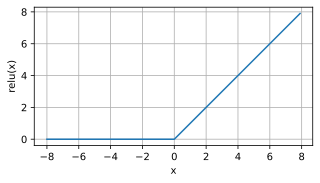

In [3]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))
## detach : 기존 Tensor 객체의 연산 그래프와의 의존성을 제거하여 메모리 사용량을 줄이고 계산 속도를 향상시킴


ReLU 함수의 미분꼴은 *heavyside function* 입니다.

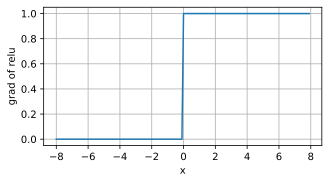

In [4]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))
## 0에서 미분이 불가함

* ReLU 함수를 직접 구현해봅시다!

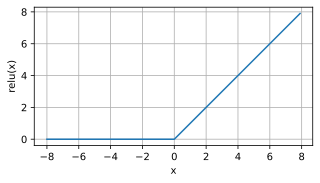

In [5]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.max(x, torch.zeros_like(x))
## torch.zeros_like(input, *, dtype=None, layout=None, device=None, requires_grad=False)
## input과 같은 크기의 0 값으로 채워진 tensor을 반환

d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

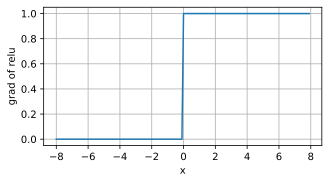

In [6]:
# Clear out previous gradients
## x.grad.data.zero_() ## error : why?

y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

### b. Sigmoid

Sigmoid 함수는 실수 전체 $\mathbb{R}$ 도메인을 $(0, 1)$ 구간으로 맵핑하는 함수입니다.

$$ \texttt{Sigmoid}(x)={1\over 1+\exp(-x)}  $$


기울기 기반 학습 과정에서 sigmoid 는 부드럽고 미분가능한 좋은 성질을 가진 함수입니다.

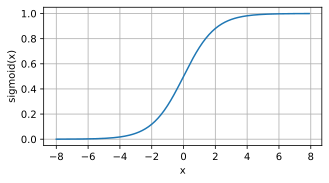

In [7]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

한편 sigmoid 함수의 미분은 다시 자기자신을 이용한 형태로 나타납니다.

$$ {d\over dx}\texttt{sigmoid}(x)={\exp(-x)\over(1+\exp(-x))^2}=\texttt{sigmoid}(x)(1-\texttt{sigmoid}(x)). $$

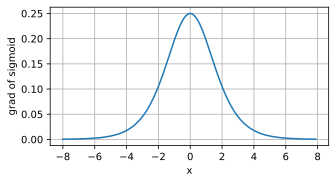

In [8]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

* Sigmoid 함수를 직접 구현해봅시다!

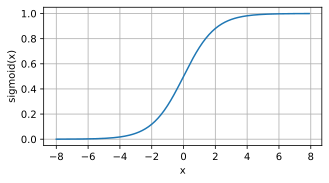

In [9]:
y = 1 / (1 + torch.exp(-x))

d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

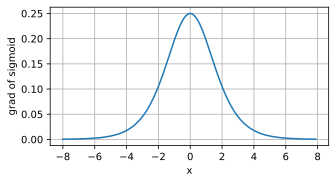

In [10]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

## 3.2 MLP implementation



In [11]:
import torch
from torch import nn, optim
from sklearn.datasets import load_breast_cancer ##, load_digits, load_wine ##

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

## Step 1. Load dataset

In [12]:
data = load_breast_cancer()

In [13]:
input = data.data
output = data.target

* GPU 사용이 가능하다면 device 를 GPU 로 설정!

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

* 데이터를 미리 설정한 device 로 이동합니다.

In [15]:
## Split datasets (30% test)
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)
## stratify : 지정한 Data의 비율을 유지한다. (taget의 데이터 비율만큼 split dataset도 그 비율을 유지)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)
## 계산을 하기 위한 데이터들에는 FloatTensor(32-bit floating Point)를, Int형 숫자를 사용할 때는 LongTensor(64-bit integer)를 사용

## Retrieve length of the inputs
x_len = len(x_train[0])
y_len = len(y_train.unique())

In [16]:
print('x_len :', x_len)
print('y_len :', y_len)

x_len : 30
y_len : 2


In [17]:
print(x_train[0])
print(y_train[0])

tensor([1.1620e+01, 1.8180e+01, 7.6380e+01, 4.0880e+02, 1.1750e-01, 1.4830e-01,
        1.0200e-01, 5.5640e-02, 1.9570e-01, 7.2550e-02, 4.1010e-01, 1.7400e+00,
        3.0270e+00, 2.7850e+01, 1.4590e-02, 3.2060e-02, 4.9610e-02, 1.8410e-02,
        1.8070e-02, 5.2170e-03, 1.3360e+01, 2.5400e+01, 8.8140e+01, 5.2810e+02,
        1.7800e-01, 2.8780e-01, 3.1860e-01, 1.4160e-01, 2.6600e-01, 9.2700e-02],
       device='cuda:0')
tensor(1, device='cuda:0')


## Step 2 : CustomDataset 과 DataLoader

In [18]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train] ## y list
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [19]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size)

## Step 3 : Define "Model"

* activation function 이용

  * nn.Sigmoid()
  * nn.ReLU()
  * nn.tanH()


* batch normazliation 1d 란?
  * 파라미터 값으로 vector의 길이를 전해줌



* a. 직접 nn.Sequential() 로 구현하기

In [20]:
# input_layer에 들어가는 최초의 input 크기를 맞춰주자!
# output_layer로 출력되는 마지막 output 의 크기도 마찬가지.

model = nn.Sequential(
          nn.Linear(x_len ,398, bias=True),
          nn.Sigmoid(),
          nn.Linear(398, 15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15, y_len, bias=True),
          nn.Softmax()
          ).to(device)

* b. 파이썬 Class 로 구현하기

In [21]:
class Model(torch.nn.Module):
# 상속 받은 후 각 레이어 정의
  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(x_len ,398, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
        ## Batch Normalization (*)
    )
    self.layer2 = nn.Sequential(
          nn.Linear(398, 15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15, 10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, y_len, bias=True), # hidden_layer3 = 10, output_layer = 2
        nn.Softmax()
    )
# forward 함수 통해 각 레이어 계산
  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


*
**Batch Normalization** : 입력 데이터를 평균과 표준편차로 정규화  
**Internal Covariant Shift** : 배치 간의 데이터 분포가 달라지는 문제점 => 해결법 : Batch Normalization  

    :torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  

num_features: 입력 데이터의 채널 수를 지정  
eps: 분모에 더해지는 작은 값, 0으로 나누는 것을 방지  
momentum: 이전 배치의 평균과 분산값을 얼마나 반영할지를 지정  
track_running_stats: 배치 정규화의 효과를 추적할지 여부를 지정

* Weight initialization

In [22]:
def init_weights(layer): # 가중치 초기화
    if isinstance(layer, nn.Linear):                    # 레이어가 linear 계산을 거치면
        torch.nn.init.xavier_uniform(layer.weight)      # 자비에 초기화 진행
                                                        # 자비에 초기화 : 가중치의 분산이 입력 데이터의 개수 n에 반비례 하도록 초기화
        layer.bias.data.fill_(0.01)                     # bias 0.01로 채움

In [23]:
model = Model().to(device) # model class 붙이기
model.apply(init_weights) # 가중치 초기화

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=30, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=2, bias=True)
    (1): Softmax(dim=None)
  )
)


<ipython-input-22-be6d6660c299>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)      # 자비에 초기화 진행


## Step 4 : Loss function 과 Optimizer

* 다양한 optimizer 가 존재
  * https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
  * https://velog.io/@minjung-s/Optimization-Algorithm

In [24]:
loss_fn  = nn.CrossEntropyLoss().to(device)

In [25]:
optimizer = optim.Adam(model.parameters(), lr= 0.01)

# Adam optimizer (Adaptive Moment Estimation)
# : Momentum과 RMSprop의 가중치 업데이트 방식을 모두 사용하여 가중치를 업데이트
# Momentum : 물리적 관성 법칙을 기반으로 가중치를 업데이트, 진행하던 속도를 그대로 유지하며 local minimum 탈출 가능성 지님
# RMSprop : 지수가중이동평균(최근 경로의 기울기가 더 많이 반영됨)을 사용하여 가중치를 업데이트
# Adam : Momentum처럼 진행하던 속도에 관성을 주고, RMSProp과 같이 학습률을 적응적으로 조정하는 알고리즘

## Step 5: Train Model

In [26]:
losses = []
for epoch in range(100):

  optimizer.zero_grad() ## optimizer 초기화
  hypothesis = model(x_train) ## 모델에 train 데이터 넣어서 예측치 얻음

  # 비용 함수
  cost = loss_fn(hypothesis, y_train) ## train data의 cost  *cross entropy loss
  cost.backward() ## loss function의 역전파
  optimizer.step() ## optimization으로 가중치 최적화
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 0.7273460030555725
10 0.5359482765197754
20 0.4567549526691437
30 0.41432684659957886
40 0.40345442295074463
50 0.40749630331993103
60 0.385957807302475
70 0.39281052350997925
80 0.39470788836479187
90 0.39987218379974365


In [27]:
#plt.plot(losses)
plt.show()

In [28]:
with torch.no_grad(): # gradient 계산 없이
  model = model.to('cpu')
  y_pred = model(x_test) # 모델에 test data 넣어서 예측치 얻음
  y_pred = y_pred.detach().numpy() # gradient 계산 떼고 numpy 형태로 변환
  predicted = np.argmax(y_pred, axis =1) # softmax 예측확률의 최대값만을 1로 반환
  accuracy = (accuracy_score(predicted, y_test)) # 정확도 예측

In [29]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.00430986 0.99569017]
argmax를 한 후의 output은 1
accuracy는 0.9064327485380117


# MLP 를 다뤄봅시다!

위 코드를 참고하여 직접 MLP 를 구현해봅시다.

load_digits() 또는 load_wine() 중 하나를 골라 시도해보세요!

- lr, optimizer, hidden layer(depth), neuron 수(width)를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!

In [30]:
from sklearn.datasets import load_wine

In [31]:
#(1) 데이터 로드 (input/output)
data = load_wine()
input = data.data
output = data.target

In [32]:
#(2) train/test set 준비

## Split datasets (30% test)
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

## Retrieve length of the inputs
x_len = len(x_train[0])
y_len = len(y_train.unique())

print('x_len :', x_len) # 13 : x의 feature 개수는 13개
print('y_len :', y_len) # 3 : y의 class 개수는 3개

x_len : 13
y_len : 3


In [33]:
print(x_train) #데이터 확인

tensor([[1.3750e+01, 1.7300e+00, 2.4100e+00,  ..., 1.1500e+00, 2.9000e+00,
         1.3200e+03],
        [1.3730e+01, 1.5000e+00, 2.7000e+00,  ..., 1.1900e+00, 2.7100e+00,
         1.2850e+03],
        [1.3280e+01, 1.6400e+00, 2.8400e+00,  ..., 1.0900e+00, 2.7800e+00,
         8.8000e+02],
        ...,
        [1.3110e+01, 1.9000e+00, 2.7500e+00,  ..., 6.1000e-01, 1.3300e+00,
         4.2500e+02],
        [1.2250e+01, 4.7200e+00, 2.5400e+00,  ..., 7.5000e-01, 1.2700e+00,
         7.2000e+02],
        [1.2640e+01, 1.3600e+00, 2.0200e+00,  ..., 9.8000e-01, 1.5900e+00,
         4.5000e+02]], device='cuda:0')


In [34]:
#(3) minibatch 나누기 (size=8)
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 1.0492892265319824
10 0.9333131313323975
20 1.0061308145523071
30 0.9526025652885437
40 0.8897132873535156
50 0.8073778748512268
60 0.8013817071914673
70 0.7941918969154358
80 0.7652826905250549
90 0.7601082921028137


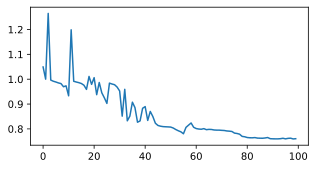

model의 output은 :  [1.0000000e+00 1.8885879e-16 4.8274742e-08]
argmax를 한 후의 output은 0
accuracy는 0.9444444444444444


In [66]:
### 크게 좋은 성능을 보이는 모델을 찾지 못함
#(4) 모델 구성하기 (input:13, output:3, 5 hidden layers, node=[500, 100, 50, 16, 8], activation : ReLU)
model = nn.Sequential(
          nn.Linear(x_len, 500, bias=True),
          nn.LeakyReLU(),
          nn.BatchNorm1d(500),
          nn.Linear(500, 100, bias=True),
          nn.LeakyReLU(),
          nn.Linear(100, 50, bias=True),
          nn.LeakyReLU(),
          nn.Linear(50, 16, bias=True),
          nn.LeakyReLU(),
          nn.Linear(16, 8, bias=True),
          nn.LeakyReLU(),
          nn.Linear(8, y_len, bias=True),
          nn.Softmax()
          ).to(device)


#(5) 가중치 초기화 구성하기 : ReLU 활성화 함수를 사용하기 때문에 자비에 초기화 대신 kaiming 초기화 사용
def init_weights(layer): # 가중치 초기화
    if isinstance(layer, nn.Linear):                    # 레이어가 linear 계산을 거치면
        torch.nn.init.kaiming_normal_(layer.weight)     # kaiming 초기화 진행
                                                        # kaiming 초기화 : 가중치의 분산이 입력 노드의 수에 반비례하도록 초기화
                                                        # ((자비에 : 가중치의 분산이 입력 데이터의 개수 n에 반비례 하도록 초기화))
        layer.bias.data.fill_(0.01)                     # bias 0.01로 채움


model.apply(init_weights) # 가중치 초기화
loss_fn  = nn.CrossEntropyLoss().to(device) # loss function

#(6) 최적화 구성하기
## 최적화 : Adam 대신 RMSprop 사용 / lr = 0.001
optimizer = optim.RMSprop(model.parameters(), lr= 0.001)
#(7) 최적화 학습
losses = []
for epoch in range(100):
  optimizer.zero_grad() ## optimizer gradient 초기화
  hypothesis = model(x_train) ## 모델에 train 데이터 넣어서 예측치 얻음

  # 비용 함수
  cost = loss_fn(hypothesis, y_train) ## train data의 cost  *cross entropy loss
  cost.backward() ## loss function의 역전파
  optimizer.step() ## optimization으로 가중치 최적화
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

plt.plot(losses) # loss plot
plt.show()

#(8) 예측
with torch.no_grad(): # gradient 계산 없이
  model = model.to('cpu')
  y_pred = model(x_test) # 모델에 test data 넣어서 예측치 얻음
  y_pred = y_pred.detach().numpy() # gradient 계산 떼고 numpy 형태로 변환
  predicted = np.argmax(y_pred, axis =1) # softmax 예측확률의 최대값만을 1로 반환
  accuracy = (accuracy_score(predicted, y_test)) # 정확도 예측

print(f'model의 output은 :  {y_pred[4]}')
print(f'argmax를 한 후의 output은 {predicted[4]}')
print(f'accuracy는 {accuracy}')

<ipython-input-67-76c0f686f95c>:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)      # 자비에 초기화 진행
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 1.1019343137741089
10 0.7616664171218872
20 0.6388545036315918
30 0.5987152457237244
40 0.5789678692817688
50 0.5840938687324524
60 0.5958187580108643
70 0.5754866003990173
80 0.5638025403022766
90 0.5572600364685059


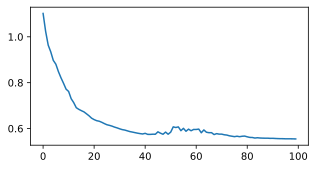

model의 output은 :  [9.9638003e-01 2.7075054e-03 9.1248506e-04]
argmax를 한 후의 output은 0
accuracy는 0.9444444444444444


In [67]:
### 예시 그대로의 모델(비교위함)
#(4) 모델 구성하기 (input:13, output:3, 4 hidden layers, node=[398, 15], activation : Sigmoid)
model = nn.Sequential(
          nn.Linear(x_len, 398, bias=True),
          nn.Sigmoid(),
          nn.BatchNorm1d(398),
          nn.Linear(398, 15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15, y_len, bias=True),
          nn.Softmax()
          ).to(device)

#(5) 가중치 초기화 구성하기
def init_weights(layer): # 가중치 초기화
    if isinstance(layer, nn.Linear):                    # 레이어가 linear 계산을 거치면
        torch.nn.init.xavier_uniform(layer.weight)      # 자비에 초기화 진행
                                                        # 자비에 초기화 : 가중치의 분산이 입력 데이터의 개수 n에 반비례 하도록 초기화
        layer.bias.data.fill_(0.01)                     # bias 0.01로 채움


model.apply(init_weights) # 가중치 초기화
loss_fn  = nn.CrossEntropyLoss().to(device) # loss function

#(6) 최적화 구성하기
## 최적화 : Adam 사용 / lr = 0.01
optimizer = optim.Adam(model.parameters(), lr= 0.01)

#(7) 최적화 학습
losses = []
for epoch in range(100):
  optimizer.zero_grad() ## optimizer gradient 초기화
  hypothesis = model(x_train) ## 모델에 train 데이터 넣어서 예측치 얻음

  # 비용 함수
  cost = loss_fn(hypothesis, y_train) ## train data의 cost  *cross entropy loss
  cost.backward() ## loss function의 역전파
  optimizer.step() ## optimization으로 가중치 최적화
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

plt.plot(losses) # loss plot
plt.show()

#(8) 예측
with torch.no_grad(): # gradient 계산 없이
  model = model.to('cpu')
  y_pred = model(x_test) # 모델에 test data 넣어서 예측치 얻음
  y_pred = y_pred.detach().numpy() # gradient 계산 떼고 numpy 형태로 변환
  predicted = np.argmax(y_pred, axis =1) # softmax 예측확률의 최대값만을 1로 반환
  accuracy = (accuracy_score(predicted, y_test)) # 정확도 예측

print(f'model의 output은 :  {y_pred[4]}')
print(f'argmax를 한 후의 output은 {predicted[4]}')
print(f'accuracy는 {accuracy}')